# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import matplotlib.pyplot as plt

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
#%connect_info

### Setup params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [3]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

## Run Default OpenCL simulation for multiple repetitions

This shows what happens with the 'default' (manually calibrated) model

In [4]:
results = OpenCLRunner.run_opencl_model_multi(
    repetitions=5, 
    iterations=100, 
    params=OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE),
    num_seed_days=10,
    store_detailed_counts=True,
    opencl_dir=OPENCL_DIR,
    snapshot_filepath=SNAPSHOT_FILEPATH,
    multiprocess=False
)

summaries = [x[0] for x in results]
final_results = [x[1] for x in results]
print("Finished")

# To make it convenient to reload later:
#pickle.dump( summaries, open( "./summaries.pkl", "wb" ) )

Running models: 100%|██████████| 5/5 [00:58<00:00, 11.61s/it]

.. finished, took 58.08s)
Finished


## Plot output summary data

### Total counts of disease status

In [23]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        ax.plot(x, observations[:len(x)], 
                label=f"Observations (cases)", color="black")
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

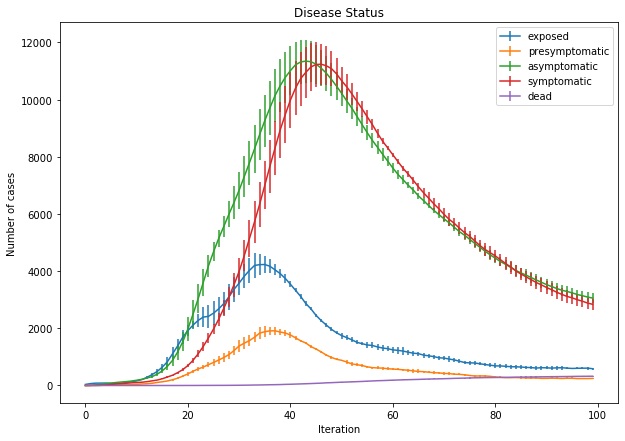

In [6]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [7]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [14]:
   
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

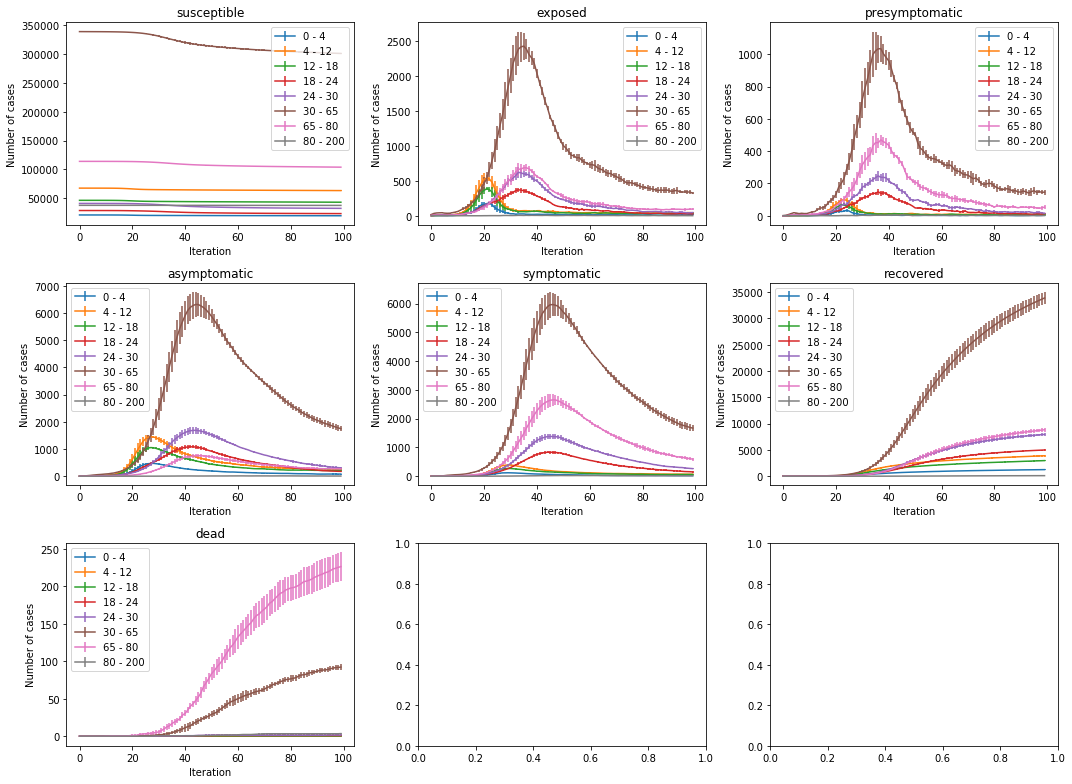

In [9]:
plot_disease_status_by_age(summaries)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


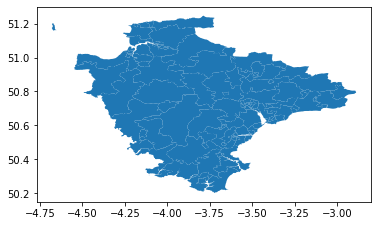

In [10]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [11]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

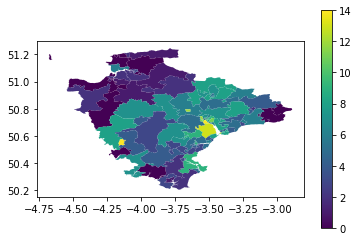

In [12]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)

## Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases.

In [5]:
observations = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )
print(f"Total cases: {sum(observations['Cases'])}")
observations

Total cases: 16371


,Day,Cases
0,1,37
1,2,38
2,3,40
3,4,41
4,5,43
...,...,...
105,106,6
106,107,6
107,108,5
108,109,5


## Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

This is implemented in `opencl_runner.OpenCLRunner.fit_l2` (see [opencl_runner.py](../opencl_runner.py)).

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

## Calibration Parameters

Which parameters will we try to calibrate on?

To begin with lets just try the `current_risk_beta` (a general multiplier for risk at locations).

Create a function that takes a value of that parameter as an argument, runs a model, and returns the result (the number of cases per day).

In [6]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5 

assert ITERATIONS < len(observations), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(observations)})."

# Initialise the class so that its ready to run the model
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = observations,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH)

Check that function works by calling it once with a couple of new parameters

In [30]:
(fitness, sim, obs, out_params, summaries) = OpenCLRunner.run_model_with_params(np.array([
    0.005,  # current_risk_beta
    0.13,  # proportion_asymptomatic
    0.75,  # infection_log_scale
    7.0,  #infection_mode
    1.0,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
]) , return_full_details=True)

# Make sure that the parameter value used in the model was set correctly
assert out_params.proportion_asymptomatic == 0.13, f"Proportion_asymptomatic should be 0.13, not {out_params.proportion_asymptomatic}"

print(f"fitness: {fitness}")
#list(zip(obs,sim))

Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.97s)
fitness: 38896.3853210038


### Calibration

Lots of different methods are available. Simulated annealing? Latin-Hypercube sampling? GA? ABC?

Start with a simple minimisation algorithm [Nelder-Mead Simplex algorithm](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#nelder-mead-simplex-algorithm-method-nelder-mead) and calibrate on the _current_risk_beta_, _proportion_asymptomatic_ and two parameters used to define disease transmissions: _infection_log_scale_ and _infection_mode_.

In [ ]:
from scipy.optimize import minimize

x0 = np.array([  # initial guesses for each variable:
    0.005,  # current_risk_beta
    0.75,  # infection_log_scale
    7.0,  #infection_mode
    1.0,  # presymptomatic
    0.75, # asymptomatic
    1.0  #symptomatic
])  

optimisation_result = minimize(OpenCLRunner.run_model_with_params, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

with open( "./optimisation_result.pkl", "wb" ) as f:
    pickle.dump( optimisation_result, f)

In [8]:
# Or can optionally load a pickle file
with open( "./optimisation_result.pkl", "rb" ) as f:
    optimisation_result = pickle.load(f)

In [26]:
np.set_printoptions(suppress=True)
print(optimisation_result.x)

[0.0009971  0.46042067 0.94009077 7.35531686]


Lets run a model with these parameters to see what happens

In [28]:
(fitness, sim, obs, out_params, summaries) = \
    OpenCLRunner.run_model_with_params(
        optimisation_result.x, return_full_details=True)

Running models: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]

.. finished, took 13.15s)


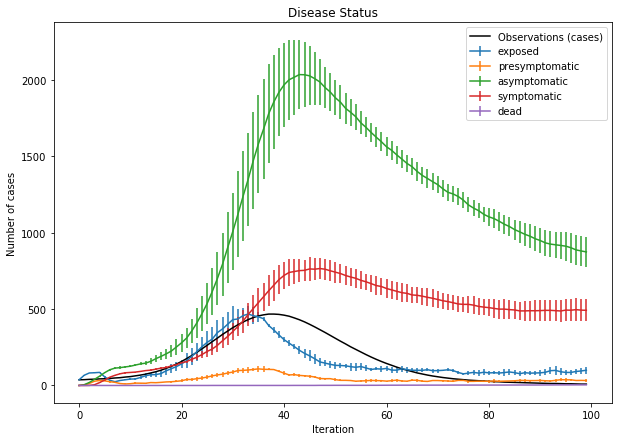

In [29]:
plot_summaries(summaries=summaries, plot_type="error_bars", observations=observations['Cases'])

In [ ]:
#plot_disease_status_by_age(summaries)